# Labor Condition Applications

As part of the H1B Visa application process, each sponsoring company must submit a Labor Condition Application (LCA) to the United States Department of Labor. With this application, the employer must show, amongst other things, that the non-immigrant worker who is applying for the H1B is being paid similarly to employees at the company doing the same work, and is receiving the prevailing wage for that occupation in the geographical area.

The Department of Labor provides a record of all submitted LCAs each year [on their website.](http://www.foreignlaborcert.doleta.gov/performancedata.cfm#dis) Along with general wage information from the department's [Bureau of Labor Statistics,](http://www.bls.gov/soc/) I've analyzed the data from 2014 to determine trends in LCA wages, applicants, and rejections.

The data used in this notebook, though downloaded from open sources, has been pre-processed by myself. To see the steps I took in doing so, please see the other associated notebook files. In many cases, outliers have been removed from the data regardless of whether they were the result of errors in the data or actually extreme values. Because this analysis is focused on broad trends in the hundreds of thousands of applicants from 2014, omitting these values will not negatively impact my analysis. 

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The input code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the input code, click <a href="javascript:code_toggle()">here</a>.''')

## Wage Analysis

Although the Department of Labor (DOL) states that H1B applicants must be paid similiarly to their domestic counterparts, I was curious to see if this was true in all cases. Furthermore, I wanted to see if there were any trends in this data, such as specific employers, industries, or occupations paying foreign workers differently.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

f = open("Delta_LCA.csv", "r")
delta_df = pd.read_csv(f, index_col=0)
f.close()

In terms of wage types, there are two major categories in the data: **hourly** and **yearly**. By plotting these groups, we can get a sense of the prevailing wages of these applicants. The mean and median US wages are sourced from the [Office of Social Security.](http://www.ssa.gov/oact/cola/central.html) When comparing hourly wages to the US national mean and median, I assume a 2087 hour work year, as specified by the [Office of Personnel Management.](http://www.opm.gov/policy-data-oversight/pay-leave/pay-administration/fact-sheets/computing-hourly-rates-of-pay-using-the-2087-hour-divisor/)

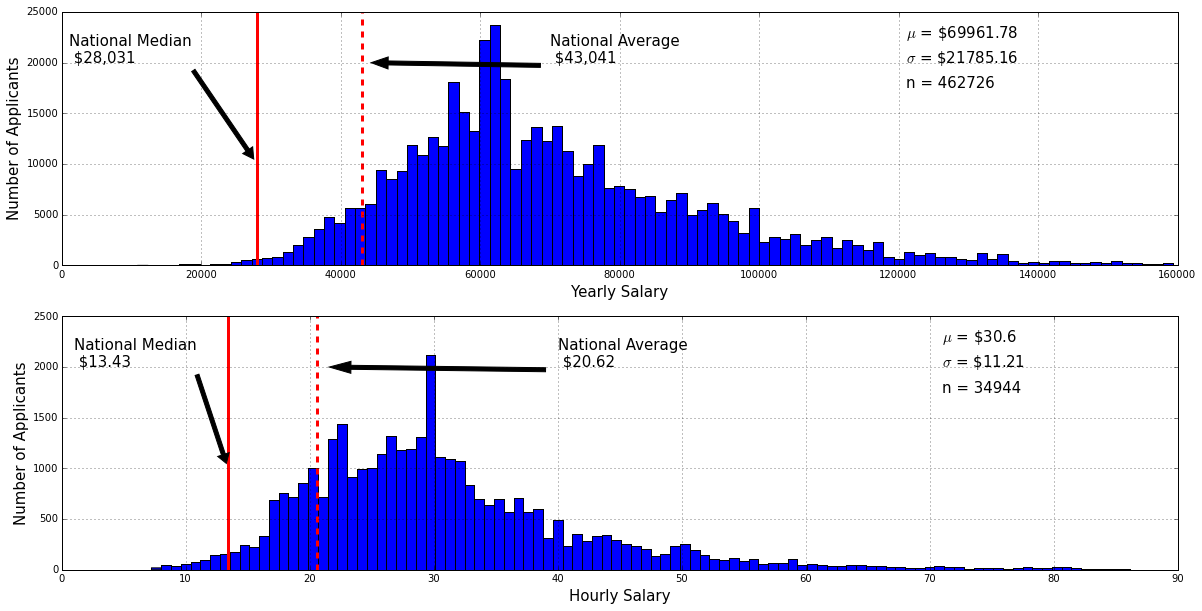

In [3]:
yearly_wages = delta_df["PW_1"][delta_df["PW_UNIT_1"] == "Year"]
hourly_wages = delta_df["PW_1"][delta_df["PW_UNIT_1"] == "Hour"]

plt.figure(figsize=(20,10))

plt.subplot(211)
plt.hist(yearly_wages, bins=100)
plt.xlabel("Yearly Salary", fontsize=15)
plt.ylabel("Number of Applicants", fontsize=15)
plt.grid(True)
plt.axvline(x=43041, ymin=0, ymax=25000, color="red", ls="--", linewidth="3")
plt.annotate('National Average \n $43,041', fontsize=15, xy=(43041, 20000), xytext=(70000, 20000),
            arrowprops=dict(facecolor='black', shrink=.05))
plt.axvline(x=28031, ymin=0, ymax=25000, color="red", ls="-", linewidth="3")
plt.annotate('National Median \n $28,031', fontsize=15, xy=(28031, 10000), xytext=(1000, 20000),
            arrowprops=dict(facecolor='black', shrink=.05))
plt.text(121000, 22500, "$\mu$ = \$" + str(round(yearly_wages.mean(), 2)), fontsize=15)
plt.text(121000, 20000, "$\sigma$ = \$" + str(round(yearly_wages.std(), 2)), fontsize=15)
plt.text(121000, 17500, "n = " + str(len(yearly_wages)), fontsize=15)


plt.subplot(212)
plt.hist(hourly_wages.values, bins=100)
plt.xlabel("Hourly Salary", fontsize=15)
plt.ylabel("Number of Applicants", fontsize=15)
plt.grid(True)
plt.axvline(x=20.62, ymin=0, ymax=2500, color="red", ls="--", linewidth="3")
plt.annotate('National Average \n $20.62', fontsize=15, xy=(20.62, 2000), xytext=(40, 2000),
            arrowprops=dict(facecolor='black', shrink=.05))
plt.axvline(x=13.43, ymin=0, ymax=2500, color="red", ls="-", linewidth="3")
plt.annotate('National Median \n $13.43', fontsize=15, xy=(13.42, 1000), xytext=(1, 2000),
            arrowprops=dict(facecolor='black', shrink=.05))
plt.text(71, 2250, "$\mu$ = \$" + str(round(hourly_wages.mean(), 2)), fontsize=15)
plt.text(71, 2000, "$\sigma$ = \$" + str(round(hourly_wages.std(), 2)), fontsize=15)
plt.text(71, 1750, "n = " + str(len(hourly_wages)), fontsize=15)

plt.show()

It is immediately apparent that foreign workers make much more than the typical American. However, these graphs do not take into account occupation and location. It would make sense that foreign workers are more often hired for high-skill, specialist positions for which the supply of domestic workers is limited. Since these positions command a higher wage, this would explain both the higher than average wage for H1B applicants and the rightward skew in both wage distributions. Furthermore, since these positions tend to be salaried, it also explains the fact that there are over ten times as many salaried H1B applicants than hourly.

Again, these graphs are not a fair representation of the wages of foreign vs. domestic workers. A more accurate metric would be the difference in wage between workers from the same state performing the same job. Each application has a Standard Occupational Classification (SOC) code which states the job function of the applicant. The Bureau of Labor Statistics also has data on the average wages for each of these codes in each state. Using these values, I can calculate the difference from the average, or delta ($\Delta$) for each applicant as a percentage. This will be the metric I use to analyze the wages of H1B applicants.

Note: For analysing wages, I will only be examining applications that were certified by the Department of Labor.

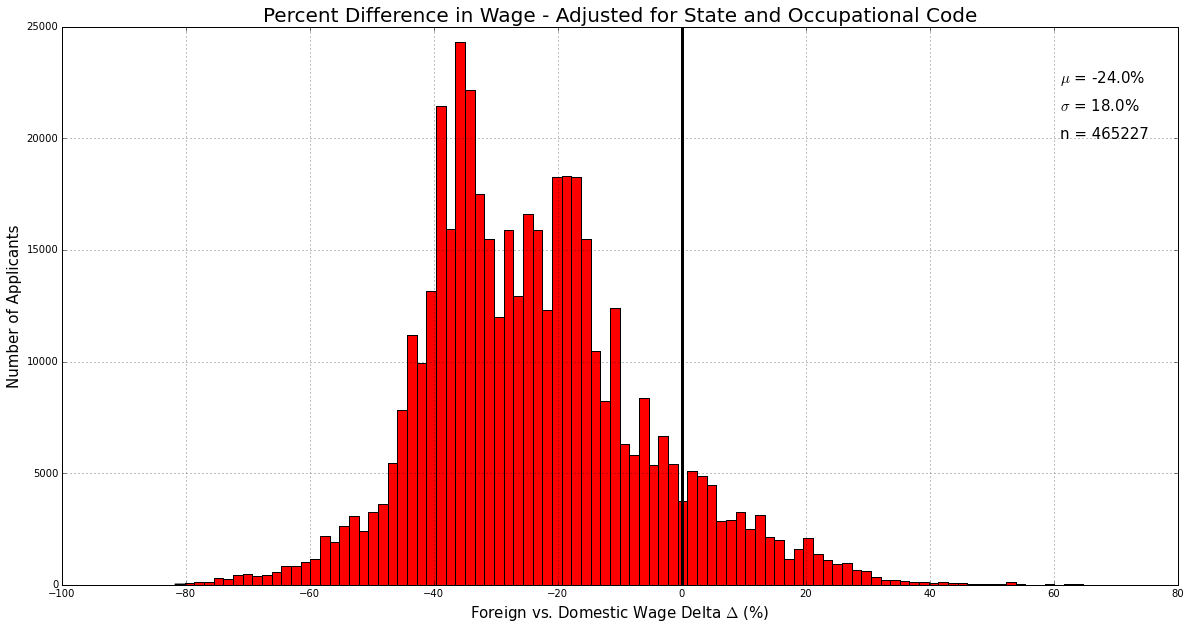

In [4]:
certified_delta_df = delta_df[delta_df.STATUS.str.contains("CERTIFIED")]

state_delta = certified_delta_df["STATE_DELTA"].dropna()

state_delta = state_delta[state_delta < state_delta.quantile(.9999)]   # Remove the most extreme outliers.
state_delta = state_delta[state_delta > state_delta.quantile(.0001)]

plt.figure(figsize=(20,10))

plt.hist(state_delta.values*100, bins=100, color = "r")
plt.title("Percent Difference in Wage - Adjusted for State and Occupational Code", fontsize=20)
plt.xlabel("Foreign vs. Domestic Wage Delta $\Delta$ (%)", fontsize=15)
plt.ylabel("Number of Applicants", fontsize=15)
plt.grid(True)
plt.axvline(x=0, ymin=0, ymax=30000, color="black", ls="-", linewidth="3")
plt.text(61, 22500, "$\mu$ = " + str(round(state_delta.mean(), 2)*100) + "%", fontsize=15)
plt.text(61, 21250, "$\sigma$ = " + str(round(state_delta.std(), 2)*100) + "%", fontsize=15)
plt.text(61, 20000, "n = " + str(len(state_delta)), fontsize=15)

plt.show()

This graph tells a very different story than the previous two. According to the data, foreign workers are typically paid 24% less than their domestic counterparts. With the given mean and standard deviation, only about 9% of foreign workers make as much as or more than domestic workers performing the same job in the same state. Furthermore, some states tend to pay foreigners less than others.

Note: This data includes Guam ("GU") and Puerto Rico ("PR").

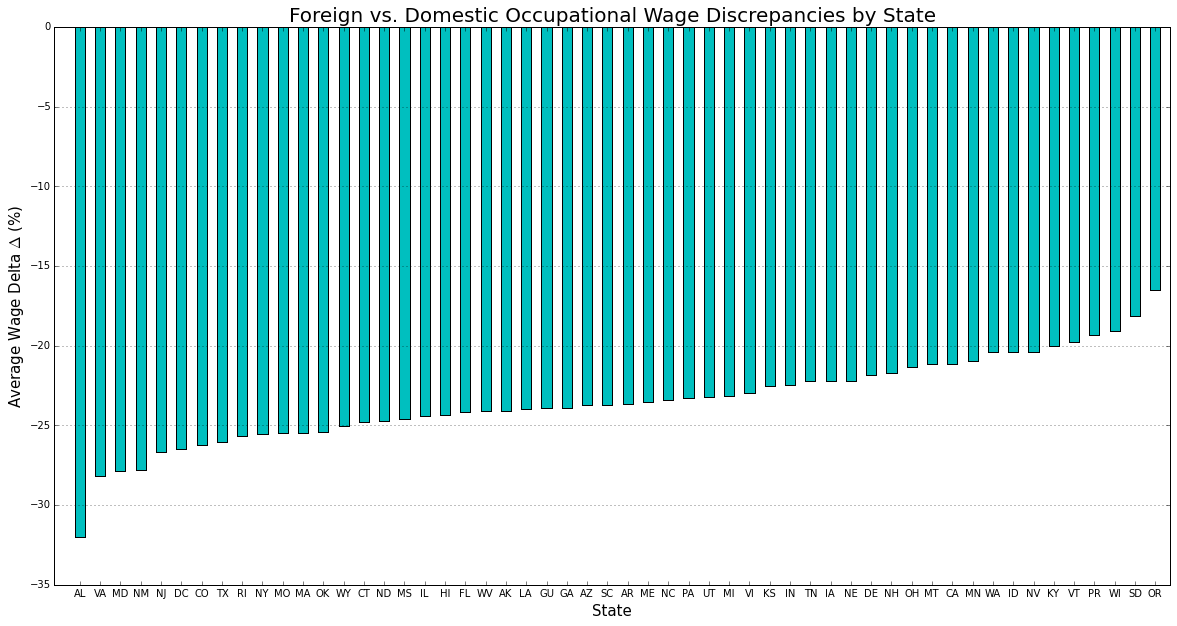

In [5]:
delta_grouped_by_state = certified_delta_df.groupby(["STATE"])
deltas_by_state = delta_grouped_by_state["STATE_DELTA"].mean().order("STATE_DELTA").dropna()
names = deltas_by_state.keys().tolist()

lefts = range(1,len(deltas_by_state)+1)
bar_widths = 0.5

plt.figure(figsize=(20,10))

plt.bar(lefts, deltas_by_state.values*100, width=bar_widths, color = "c")
plt.grid(True, axis="y")
plt.title("Foreign vs. Domestic Occupational Wage Discrepancies by State", fontsize=20)
plt.xlim(0, 55)
plt.xticks([0.25+x for x in lefts], names)
plt.xlabel("State", fontsize=15)
plt.ylabel("Average Wage Delta $\Delta$ (%)", fontsize=15)

plt.show()

Alabama seems to pay foreign workers considerably worse than most states, while Oregon, though still averaging -16.5%, tends to pay H1B workers the closest to their domestic counterparts. At this point, I can safely say that despite the LCA, foreign workers are *not* being paid the same as Americans. That said, individual industries and occupations show a wide range of wage dicrepancy, regardless of state.

Although the best paying industry is an outlier (which I will explore shortly), the difference in Delta between the two worst and two next best industries is still substantial.

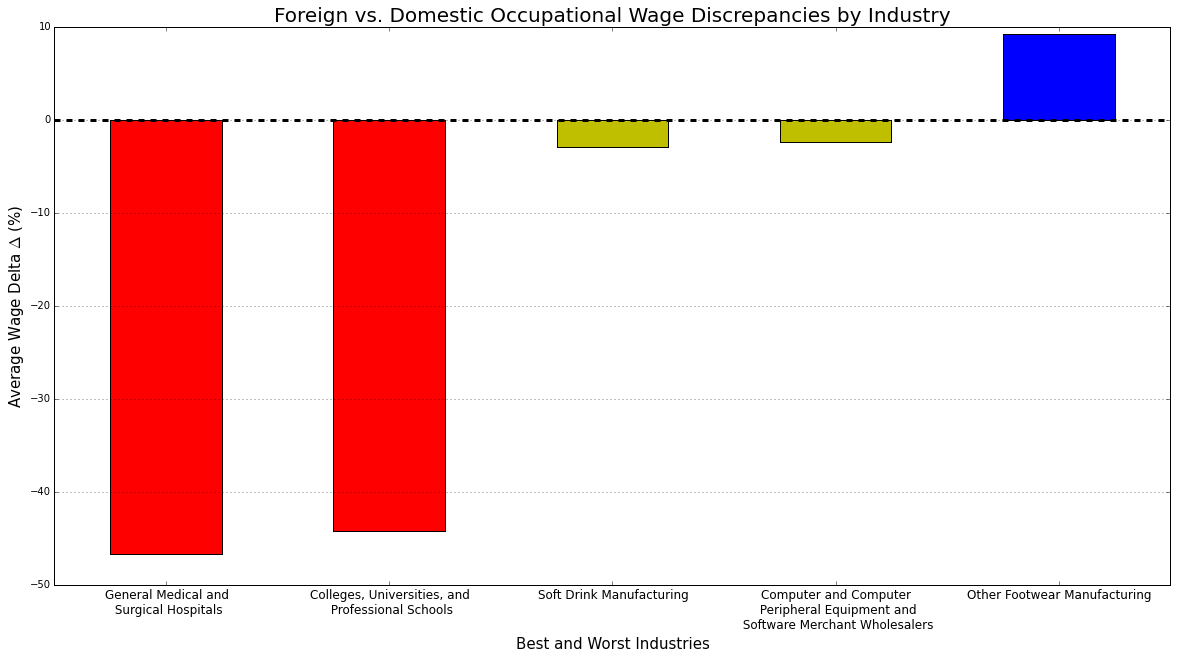

In [6]:
# Only industries with at least 100 applicants will be examined in this graph.

delta_grouped_by_industry = certified_delta_df.groupby(["LCA_CASE_NAICS_CODE"])
valid_industries = delta_grouped_by_industry.size()[delta_grouped_by_industry.size() > 100].keys()

valid_industry_df = certified_delta_df[certified_delta_df["LCA_CASE_NAICS_CODE"].isin(valid_industries)]
delta_grouped_by_industry = valid_industry_df.groupby(["LCA_CASE_NAICS_CODE"])
industry_deltas = delta_grouped_by_industry["STATE_DELTA"].mean().order("STATE_DELTA").dropna()

industry_values = industry_deltas.head(2).values.tolist() + industry_deltas.tail(3).values.tolist()
industry_names = ["General Medical and \n Surgical Hospitals", "Colleges, Universities, and \n Professional Schools", 
                 "Soft Drink Manufacturing", 
                  "Computer and Computer \n Peripheral Equipment and \n Software Merchant Wholesalers",
                 "Other Footwear Manufacturing"]
colors = ["r", "r", "y", "y", "b"]

lefts = range(1,len(industry_names)+1)
bar_widths = 0.5

plt.figure(figsize=(20,10))

plt.bar(lefts, [100*x for x in industry_values], width=bar_widths, color = colors)
plt.grid(True, axis="y")
plt.title("Foreign vs. Domestic Occupational Wage Discrepancies by Industry", fontsize=20)
plt.xticks([0.25+x for x in lefts], industry_names, fontsize=12)
plt.xlabel("Best and Worst Industries", fontsize=15)
plt.xlim(0.75, 5.75)
plt.ylabel("Average Wage Delta $\Delta$ (%)", fontsize=15)
plt.axhline(y=0, xmin=0, xmax=30000, color="black", ls="--", linewidth="3")

plt.show()


As it turns out, Hospitals and Universities are by far the worst when it comes to paying foreign workers fairly. In general, manufacturing and technology fields tend to pay their foreign workers fairly well. There is one very unusual outlier in "Other Footwear Manufacturing", however. This is because that particular industry is dominated by a single company, **Nike Inc**, which is headquartered in Oregon, the state with the lowest average wage delta. Furthermore, as the largest company in Oregon, it can be assumed that Nike would pay all of its employees a high wage relative to other companies in the state. Given this information, Nike seems to be a good choice of employer for foreigners looking to work in the United States.

Examining the difference in wages by Occupational Classification further highlights the extent of the pay gap.

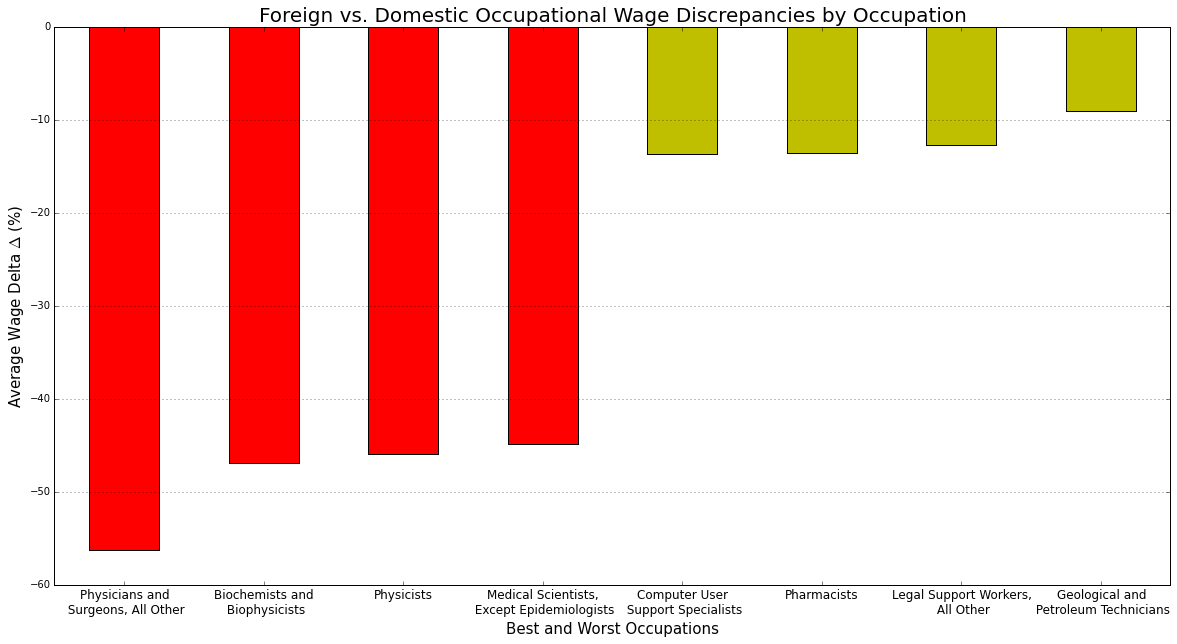

In [7]:
# Only occupations with at least 100 applicants will be examined in this graph.

delta_grouped_by_job = certified_delta_df.groupby(["LCA_CASE_SOC_NAME"])
valid_jobs = delta_grouped_by_job.size()[delta_grouped_by_job.size() > 100].keys()

valid_job_df = certified_delta_df[certified_delta_df["LCA_CASE_SOC_NAME"].isin(valid_jobs)]
delta_grouped_by_job = valid_job_df.groupby(["LCA_CASE_SOC_NAME"])
job_deltas = delta_grouped_by_job["STATE_DELTA"].mean().order("STATE_DELTA").dropna()

job_values = job_deltas.head(4).values.tolist() + job_deltas.tail(4).values.tolist()
job_names = ["Physicians and \n Surgeons, All Other", "Biochemists and \n Biophysicists", "Physicists", 
            "Medical Scientists, \n Except Epidemiologists", "Computer User \n Support Specialists",
            "Pharmacists", "Legal Support Workers, \n All Other", "Geological and \n Petroleum Technicians"]
colors = ["r", "r", "r", "r", "y", "y", "y", "y"]

lefts = range(1,len(job_names)+1)
bar_widths = 0.5

plt.figure(figsize=(20,10))

plt.bar(lefts, [100*x for x in job_values], width=bar_widths, color = colors)
plt.grid(True, axis="y")
plt.title("Foreign vs. Domestic Occupational Wage Discrepancies by Occupation", fontsize=20)
plt.xticks([0.25+x for x in lefts], job_names, fontsize=12)
plt.xlabel("Best and Worst Occupations", fontsize=15)
plt.xlim(0.75, 8.75)
plt.ylabel("Average Wage Delta $\Delta$ (%)", fontsize=15)

plt.show()

Again, we see Doctors and Scientists being paid **considerably** below average. In the case of Physicians and Surgeons, over 50% beloew the state average. How can this be possible, given that the purpose of the LCA is to ensure that foreign workers are paid similarly to their domestic counterparts? Are hospitals really paying foreign Doctors less than half of their American colleagues? Do Stanford and Harvard discriminate against foreign Scientists?

Remember that the metric we are using, Average Wage Delta, only shows the difference in wage based on occupation. This metric is limited because people in the same occupation can work in different industries and at different companies, some of which **are not available to foreign workers.** The biggest examples of these are Private Medical Practices and Government Contractors.

In the case of Medical Professionals, those who work in or own their own private practice make considerably more money than those working at hospitals. However, this option is not availble to H1B applicants, as they require a company (such as a hospital) to sponsor them. As such, foreign Doctors are forced to work the lowest-paying options in the field. This theory is supported by the fact that Pharmacists, Medical Professionals who typically do not work at private practices, show some of the lowest Wage Deltas.

For scientists, the highest-paid positions are in private industry. However, these positions often involve working on government contracts (such as research positions at Lockheed Martin), which require US Citizenship. Because foreign workers are barred from these positions, their primary option is to work at the universities, which pay far less for the same work.

Much like when the Shoe industry seemed to over pay foreign workers because Nike was the largest employer in the state and the largest employer in that industry, it is important to recognize the limitations of our metrics when performing analysis.

Finally, let's examine individual companies. Although we now know to expect universities and hospitals at the bottom, it would be interesting to see if any large companies pay foreign workers particularly well. For this final graph, I will only examine companies that filled at least 250 applications. Note that this excludes Nike, which would otherwise be far ahead of the competition.

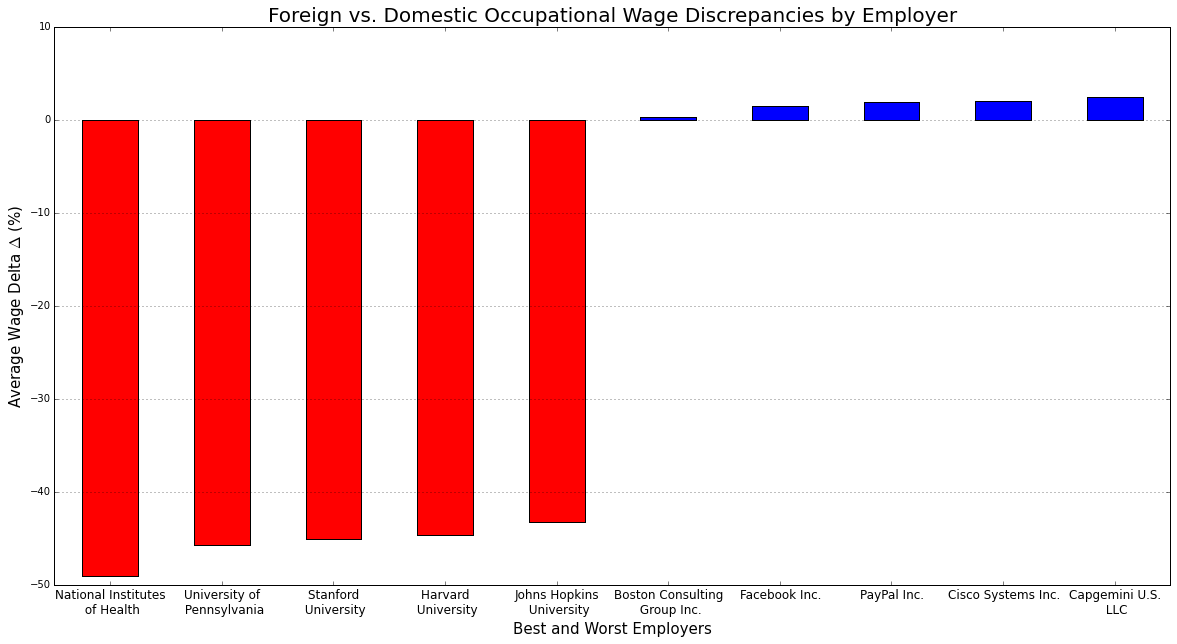

In [8]:
delta_grouped_by_company = certified_delta_df.groupby(["LCA_CASE_EMPLOYER_NAME"])
valid_companies = delta_grouped_by_company.size()[delta_grouped_by_company.size() > 250].keys()

valid_company_df = certified_delta_df[certified_delta_df["LCA_CASE_EMPLOYER_NAME"].isin(valid_companies)]
delta_grouped_by_company = valid_company_df.groupby(["LCA_CASE_EMPLOYER_NAME"])

company_deltas = delta_grouped_by_company["STATE_DELTA"].mean().order("STATE_DELTA").dropna()

company_values = company_deltas.head().values.tolist() + company_deltas.tail().values.tolist()
company_names = ["National Institutes \n of Health", "University of \n Pennsylvania", "Stanford \n University", 
            "Harvard \n University", "Johns Hopkins \n University", "Boston Consulting \n Group Inc.", 
            "Facebook Inc.", "PayPal Inc.", "Cisco Systems Inc.", "Capgemini U.S. \n LLC"]
colors = ["r", "r", "r", "r", "r", "b", "b", "b", "b", "b"]

lefts = range(1,len(company_names)+1)
bar_widths = 0.5

plt.figure(figsize=(20,10))

plt.bar(lefts, [100*x for x in company_values], width=bar_widths, color = colors)
plt.grid(True, axis="y")
plt.title("Foreign vs. Domestic Occupational Wage Discrepancies by Employer", fontsize=20)
plt.xticks([0.25+x for x in lefts], company_names, fontsize=12)
plt.xlabel("Best and Worst Employers", fontsize=15)
plt.xlim(0.75, 10.75)
plt.ylabel("Average Wage Delta $\Delta$ (%)", fontsize=15)

plt.show()

As expected, universities and research institutions filled the bottom five slots. The top five large companies actually show a positive Wage Delta though. Again, this is due to the fact that these companies pay well in general, but large, competative companies that hire technical professionals present the best options for H1B applicants looking to make as much money as their American counterparts.

## Applicant Density